# Import Libraries

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, regularizers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Data

## Exploring/visualizing data

In [2]:
labels = pd.read_csv("drive/My Drive/Dog Breed/dog-breed-identification/labels.csv")
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [ ]:
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,fff43b07992508bc822f33d8ffd902ae,scottish_deerhound
freq,1,126


In [ ]:
labels["breed"].value_counts()

,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
...,...
golden_retriever,67
komondor,67
brabancon_griffon,67


<Axes: xlabel='breed'>

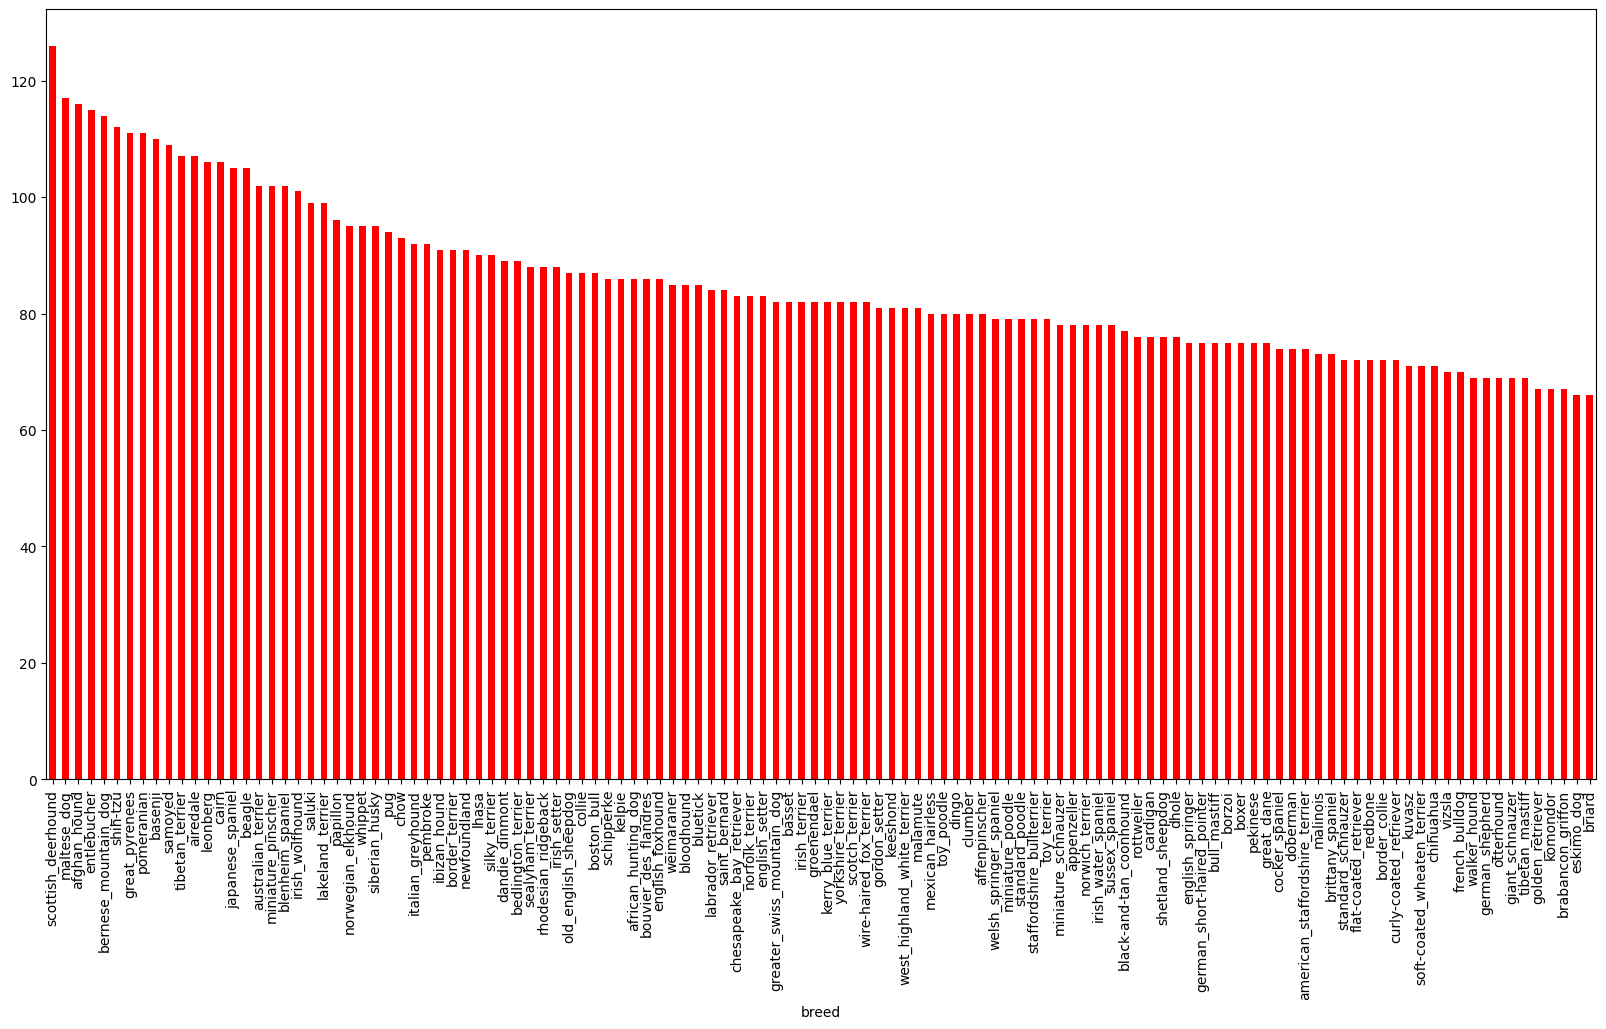

In [ ]:
# Visualize the value counts
labels["breed"].value_counts().plot.bar(figsize = (20,10), color = "red")

In [ ]:
labels["breed"].value_counts().mean()

np.float64(85.18333333333334)

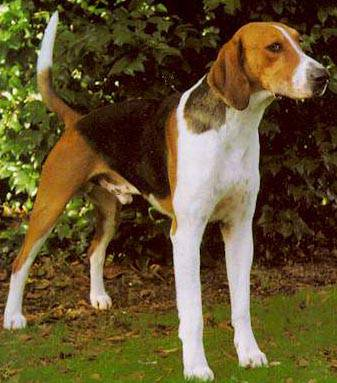

In [ ]:
# Viewing an image from the train data
from IPython.display import Image
Image("drive/MyDrive/Dog Breed/dog-breed-identification/train/ffca1c97cea5fada05b8646998a5b788.jpg")

In [3]:
# Creating a filename path for all the images
filenames = ["drive/MyDrive/Dog Breed/dog-breed-identification/train/" + filename + ".jpg" for filename in labels["id"]]
filenames[:5]


['drive/MyDrive/Dog Breed/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Breed/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Breed/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Breed/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Breed/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [ ]:
# Checking whether the number of file in labels is the same as train
import os
len(filenames) == len(os.listdir("drive/MyDrive/Dog Breed/dog-breed-identification/train"))

True

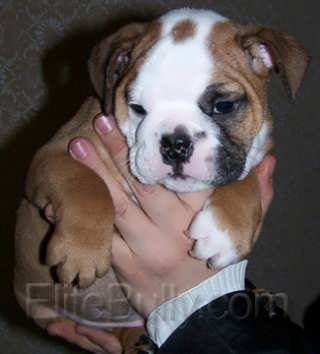

In [ ]:
Image(filenames[6000])

In [ ]:
labels["breed"][6000]

'french_bulldog'

The dog in the image above is a `french bulldog`

In [ ]:
len(labels)

10222

In [4]:
breeds = np.array(labels["breed"])
breeds

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(breeds)

10222

In [5]:
unique_breeds = np.unique(breeds)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [ ]:
len(unique_breeds)

120

There are actually 120 breeds of dogs in the dataset


In [ ]:
breeds[6000] == unique_breeds

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [6]:
boolean_labels = [breed == unique_breeds for breed in breeds]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

Each value in the boolean label array will be in False/True format, where True indicates the breed name corresponding to that label.

In [ ]:
len(boolean_labels)

10222

## Separating train and validation data

In [7]:
# Define X and y variables
X = filenames
y = boolean_labels

In [8]:
np.random.seed(42)
y_array = np.array(y)  # Converts the list of boolean one-hot labels into a NumPy array

stratify = y_array.argmax(axis=1)  # Creates a 1D array of class indices based on the position of True (i.e., the highest value in each one-hot label)

X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size = 0.2,
                                                  stratify = stratify)

In [9]:
X_train[:2], y_train[:2]

(['drive/MyDrive/Dog Breed/dog-breed-identification/train/2f812a0cb6977bbad1a167e1ef4ae2ac.jpg',
  'drive/MyDrive/Dog Breed/dog-breed-identification/train/123c19c8d168e7704273cb7174351821.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False,  True, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         Fals

In [10]:
X_val[:2], y_val[:2]

(['drive/MyDrive/Dog Breed/dog-breed-identification/train/77adbcd124ca77b78044211f06ed0240.jpg',
  'drive/MyDrive/Dog Breed/dog-breed-identification/train/e47cac448a3250262bee5660d393da9a.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False,  True, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         Fals

# Turning Images into Tensors


In [11]:
# Convert image into a numpy array
from matplotlib.pyplot import imread
image1 = imread(filenames[2])
image1.shape

(375, 500, 3)

height = 375, width = 500, 3 there represent RGB, all the colours in the image are RGB or generated from combination of any of them which ranges from 0 - 255

In [ ]:
image1.min(), image1.max()

(np.uint8(0), np.uint8(255))

In [ ]:
image1[:5]

array([[[ 97,  96,  91],
        [102, 101,  96],
        [108, 107, 102],
        ...,
        [ 10,  12,  11],
        [ 10,  12,  11],
        [ 10,  12,  11]],

       [[ 99,  98,  93],
        [102, 101,  96],
        [108, 107, 102],
        ...,
        [ 18,  20,  19],
        [ 18,  20,  19],
        [ 18,  20,  19]],

       [[ 99,  98,  93],
        [ 99,  98,  93],
        [102, 101,  96],
        ...,
        [  8,   8,   8],
        [  8,   8,   8],
        [  8,   8,   8]],

       [[ 97,  96,  91],
        [ 94,  93,  88],
        [ 93,  92,  87],
        ...,
        [ 12,  12,  12],
        [ 12,  12,  12],
        [ 12,  12,  12]],

       [[ 97,  96,  92],
        [ 92,  91,  87],
        [ 88,  87,  83],
        ...,
        [ 13,  13,  13],
        [ 13,  13,  13],
        [ 13,  13,  13]]], dtype=uint8)

In [ ]:
# Turn the numpy array image to tensor
tf.constant(image1)

<tf.Tensor: shape=(375, 500, 3), dtype=uint8, numpy=
array([[[ 97,  96,  91],
        [102, 101,  96],
        [108, 107, 102],
        ...,
        [ 10,  12,  11],
        [ 10,  12,  11],
        [ 10,  12,  11]],

       [[ 99,  98,  93],
        [102, 101,  96],
        [108, 107, 102],
        ...,
        [ 18,  20,  19],
        [ 18,  20,  19],
        [ 18,  20,  19]],

       [[ 99,  98,  93],
        [ 99,  98,  93],
        [102, 101,  96],
        ...,
        [  8,   8,   8],
        [  8,   8,   8],
        [  8,   8,   8]],

       ...,

       [[193, 192, 188],
        [194, 193, 189],
        [195, 194, 190],
        ...,
        [118, 117, 113],
        [130, 129, 127],
        [128, 127, 123]],

       [[199, 198, 194],
        [200, 199, 195],
        [201, 200, 196],
        ...,
        [116, 115, 110],
        [107, 106, 102],
        [108, 107, 102]],

       [[199, 198, 194],
        [200, 199, 195],
        [202, 201, 197],
        ...,
        [ 96,  96,  8

## Preprocess the image

* Take in the image path
* convert it into a tensor with 3 color channels (RGB)
* resize it to the input shape expected by the pre-trained model and
* finally apply model-specific preprocessing to match the format the model was originally trained on.

In [12]:
img_size = 224

def process_image(image_path, img_size=img_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_size, img_size])
    image = tf.cast(image, tf.float32)
    return image



# Turning data into batches

This is necessary for efficient memory usage and model training. To work effectively with TensorFlow, data needs to be organized in batches as Tensor tuples of the form `(image, label).`

In [ ]:
# Tensor tuples in the form of (image, label)

(process_image(X[2]), tf.constant(y[2]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[ 99.93074  ,  99.93074  ,  91.93074  ],
         [111.627594 , 111.627594 , 103.627594 ],
         [113.095085 , 113.095085 , 105.095085 ],
         ...,
         [ 14.7814865,   5.711397 ,   4.9410152],
         [ 13.392839 ,  12.000017 ,  12.696428 ],
         [ 11.696428 ,  13.696428 ,  12.696428 ]],
 
        [[ 98.566246 ,  97.566246 ,  92.566246 ],
         [106.119995 , 105.119995 , 100.119995 ],
         [110.454475 , 109.454475 , 104.454475 ],
         ...,
         [ 23.203062 ,  13.203061 ,  12.122708 ],
         [  7.7410545,   6.3482323,   7.0446434],
         [  6.0446434,   8.044643 ,   7.0446434]],
 
        [[ 93.99271  ,  92.99271  ,  87.99271  ],
         [ 90.32677  ,  89.32677  ,  84.32677  ],
         [101.74334  , 100.74334  ,  95.74334  ],
         ...,
         [ 60.22541  ,  51.595947 ,  49.830326 ],
         [ 12.485699 ,  10.884837 ,  11.685268 ],
         [ 11.370536 ,  12.       ,  11.685268

In [13]:
# Creating a function
def image_label(image_path, label):
  image = process_image(image_path)
  label = tf.cast(label, tf.float32)
  return image, label

In [14]:
image_label(X[2], y[2])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[ 99.93074  ,  99.93074  ,  91.93074  ],
         [111.627594 , 111.627594 , 103.627594 ],
         [113.095085 , 113.095085 , 105.095085 ],
         ...,
         [ 14.7814865,   5.711397 ,   4.9410152],
         [ 13.392839 ,  12.000017 ,  12.696428 ],
         [ 11.696428 ,  13.696428 ,  12.696428 ]],
 
        [[ 98.566246 ,  97.566246 ,  92.566246 ],
         [106.119995 , 105.119995 , 100.119995 ],
         [110.454475 , 109.454475 , 104.454475 ],
         ...,
         [ 23.203062 ,  13.203061 ,  12.122708 ],
         [  7.7410545,   6.3482323,   7.0446434],
         [  6.0446434,   8.044643 ,   7.0446434]],
 
        [[ 93.99271  ,  92.99271  ,  87.99271  ],
         [ 90.32677  ,  89.32677  ,  84.32677  ],
         [101.74334  , 100.74334  ,  95.74334  ],
         ...,
         [ 60.22541  ,  51.595947 ,  49.830326 ],
         [ 12.485699 ,  10.884837 ,  11.685268 ],
         [ 11.370536 ,  12.       ,  11.685268

## Creating data batches

In [15]:
batch_size = 32

def data_batches(image_path, labels = None, batch_size = batch_size, valid_data = False, test_data = False):
  if valid_data:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(image_path), # filepaths
                                                tf.constant(labels))) # labels
    data_batch = data.map(image_label).batch(batch_size)
    return data_batch

  elif test_data:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(image_path)))
    data_batch = data.map(image_label).batch(batch_size)
    return data_batch

  else:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(image_path),
                                               tf.constant(labels)))
    data = data.shuffle(buffer_size = len(X))
    data_batch = data.map(image_label).batch(batch_size)
    return data_batch

**Note:**
* Shuffling before mapping (before loading and processing images) is faster because it shuffles just the paths and labels, not large image data.
* Shuffling the training data helps the model learn better by preventing it from seeing the same order of samples every epoch.

In [16]:
# Create data batches for train and validation data
train_batches = data_batches(X_train, y_train)
val_batches = data_batches(X_val, y_val, valid_data = True)

In [17]:
train_batches.element_spec, val_batches.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.float32, name=None)))

## Visualizing images in the train data batch

To visualize, I have to unbatchify first

In [18]:
# Unbatchify
train_images, train_labels = next(train_batches.as_numpy_iterator())
train_images[0], train_labels[0]

(array([[[ 96.31971  ,  80.31971  ,  44.319714 ],
         [123.01407  , 101.31764  ,  64.31764  ],
         [132.60304  , 104.44233  ,  67.36197  ],
         ...,
         [  2.8392944,  10.839294 ,   0.       ],
         [  7.897995 ,  12.897995 ,   6.0497894],
         [  6.093737 ,  11.093737 ,   5.093737 ]],
 
        [[ 94.26136  ,  78.26136  ,  42.26136  ],
         [121.412346 ,  99.30317  ,  63.84499  ],
         [131.0759   , 102.467674 ,  66.80804  ],
         ...,
         [  4.367154 ,  10.367154 ,   0.       ],
         [  9.361599 ,  14.361599 ,   7.3615985],
         [  7.1294513,  12.129452 ,   5.1294513]],
 
        [[ 90.76483  ,  74.76483  ,  40.764828 ],
         [119.5057   ,  96.96106  ,  62.809273 ],
         [129.96608  , 100.88572  ,  66.725006 ],
         ...,
         [  7.7973247,  10.797324 ,   0.       ],
         [ 12.180866 ,  16.370527 ,   8.560187 ],
         [  9.13838  ,  14.13838  ,   7.1383796]],
 
        ...,
 
        [[158.85606  , 172.85606  

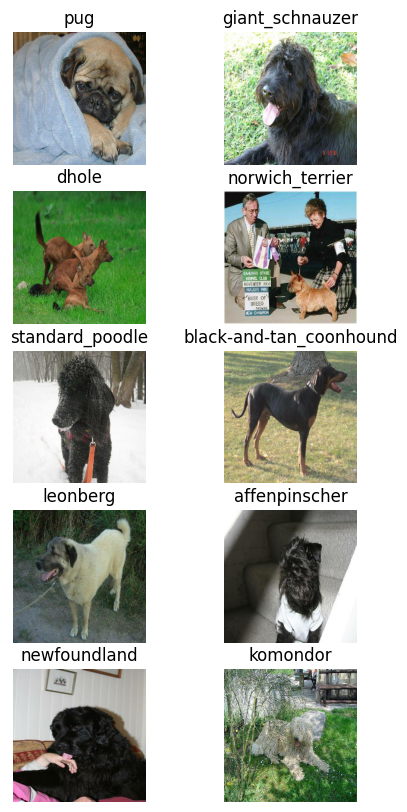

In [19]:
# Visualize the images

plt.figure(figsize = (5,10))
for i in range(10):
  ax = plt.subplot(5,2, i+1)

  image = train_images[i].copy()

  image = image.astype(np.uint8)


  plt.imshow(image)
  plt.title(unique_breeds[train_labels[i].argmax()])
  plt.axis("off")
plt.show();

# Building a model

In [20]:
input_shape = (img_size, img_size, 3)
output_shape = len(unique_breeds)

In [ ]:


def create_model(input_shape=(224, 224, 3), output_shape=120, fine_tune_at=140):
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ], name="data_augmentation")

    base_model = ResNet50(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )

    # Freeze layers up to fine_tune_at
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    x = data_augmentation(inputs)    # outputs floats [0,1]
    #x = x * 255.0                   # scale up to [0,255]
    x = preprocess_input(x)         # now preprocess_input works correctly

    x = base_model(x, training=False)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(output_shape, activation='softmax')(x)

    model = Model(inputs, outputs, name="resnet50_classifier")

    model.compile(
        optimizer=Adam(learning_rate=5e-5),
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy"]
    )

    return model










By applying softmax, each component will be in the interval
(0, 1) and the components will add up to 1


## Creating callbacks

In [ ]:
# building a TensorBoard callback
%load_ext tensorboard

import datetime    # to access the current date and time

#Create a logs directory for storing TensorBoard logs
logdir = os.path.join("drive/MyDrive/Dog Vision/logs",
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))  # strftime - string from time
tensorboard = tf.keras.callbacks.TensorBoard(logdir)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Creaate early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                                  patience = 5,
                                                  restore_best_weights=True) # keeps the best version of the model

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=3,
                              min_lr=1e-6,
                              verbose=1)

In [ ]:
model = create_model()
model.summary()

Model: "resnet50_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_10[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 512)       │  1,049,088 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 512)       │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │    131,328 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 120)       │     30,840 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,798,968 (94.60 MB)

 Trainable params: 16,189,304 (61.76 MB)

 Non-trainable params: 8,609,664 (32.84 MB)

In [ ]:
# Fit the model and use the callbacks
history = model.fit(x = train_batches,
          epochs = 30,
          validation_data = val_batches,
          validation_freq = 1,   # to test the pattern that it has found in the training set on the validation data, every epoch
          callbacks = [tensorboard, early_stopping, reduce_lr])

Epoch 1/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 163s 569ms/step - accuracy: 0.0210 - loss: 16.1910 - val_accuracy: 0.2494 - val_loss: 14.1831 - learning_rate: 5.0000e-05
Epoch 2/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 116s 233ms/step - accuracy: 0.1253 - loss: 14.1448 - val_accuracy: 0.4846 - val_loss: 12.0540 - learning_rate: 5.0000e-05
Epoch 3/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 83s 236ms/step - accuracy: 0.2919 - loss: 12.2831 - val_accuracy: 0.6059 - val_loss: 10.4701 - learning_rate: 5.0000e-05
Epoch 4/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 95s 289ms/step - accuracy: 0.4080 - loss: 10.8843 - val_accuracy: 0.6567 - val_loss: 9.4500 - learning_rate: 5.0000e-05
Epoch 5/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 70s 242ms/step - accuracy: 0.5031 - loss: 9.7839 - val_accuracy: 0.6792 - val_loss: 8.6659 - learning_rate: 5.0000e-05
Epoch 6/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 63s 247ms/step - accuracy: 0.5729 - loss: 8.9349 - val_accuracy: 0.7071 - val_loss: 7.9778 - learning_rate: 5.0000e-05
Epoch 7/30
256/256 ━━━━━━━━━━━━━━━━━━

In [ ]:
# save the model

model_name = "ResNet50"
# Create a model directory pathname with current time
modeldir = os.path.join("drive/MyDrive/Dog Breed/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
model_path = modeldir + "_" + model_name + ".keras"   # save format of model
model.save(model_path)


In [ ]:
hist = history.history

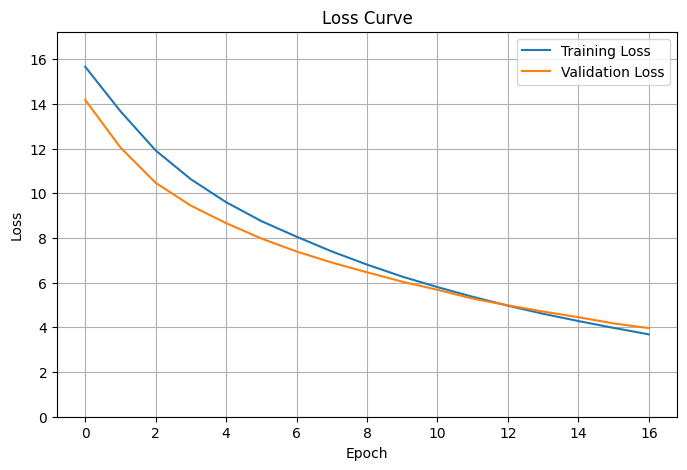

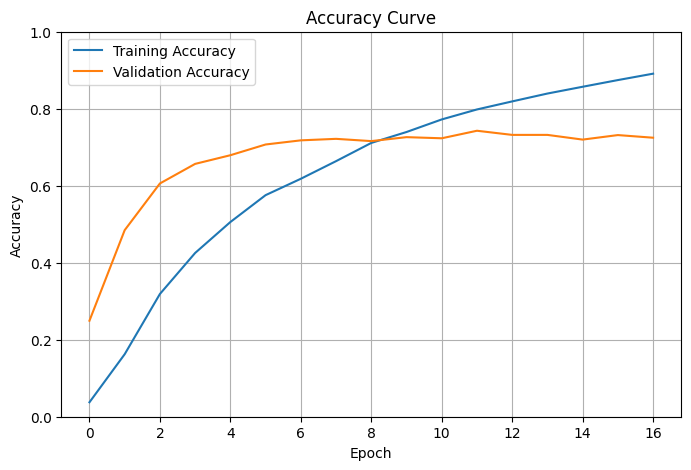

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(hist["loss"], label="Training Loss")
plt.plot(hist["val_loss"], label="Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.ylim([0, max(max(hist["loss"]), max(hist["val_loss"])) * 1.1])  # dynamic y-limit a bit above max loss
plt.legend()
plt.title("Loss Curve")
plt.grid(True)

# Plot training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(hist["accuracy"], label="Training Accuracy")
plt.plot(hist["val_accuracy"], label="Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.ylim([0, 1])
plt.legend()
plt.title("Accuracy Curve")
plt.grid(True)

plt.show()


# Checking predictions

In [23]:
model.evaluate(val_batches)

64/64 ━━━━━━━━━━━━━━━━━━━━ 408s 6s/step - accuracy: 0.7382 - loss: 5.3026


[5.287881374359131, 0.7427873015403748]

In [26]:
predictions = model.predict(val_batches, verbose = 1)
predictions

64/64 ━━━━━━━━━━━━━━━━━━━━ 406s 6s/step


array([[1.7827821e-03, 2.4694598e-03, 4.4172449e-04, ..., 2.2350738e-03,
        2.3705672e-02, 1.0712803e-03],
       [8.6292224e-05, 1.4110059e-04, 2.0796317e-04, ..., 2.6036036e-04,
        3.0784216e-04, 3.1754945e-04],
       [1.2606331e-04, 2.9045113e-04, 9.4094452e-05, ..., 4.1765154e-05,
        1.4152001e-04, 3.8655009e-05],
       ...,
       [2.3298839e-05, 9.1445982e-05, 2.1191906e-04, ..., 6.2881259e-04,
        1.9806148e-04, 5.9699600e-05],
       [3.2083511e-03, 2.5402701e-03, 4.4783819e-03, ..., 2.2054102e-02,
        1.5686102e-03, 4.3039354e-03],
       [1.8947905e-02, 9.8854816e-04, 2.2703833e-03, ..., 1.2572984e-03,
        2.1364128e-03, 6.6467044e-03]], dtype=float32)

In [ ]:
predictions[0]

array([0.00178278, 0.00246946, 0.00044173, 0.00426407, 0.0012546 ,
       0.00203967, 0.00062522, 0.00159888, 0.00549996, 0.00202737,
       0.3699429 , 0.00253133, 0.00152771, 0.00083261, 0.00105872,
       0.026651  , 0.00180821, 0.00333089, 0.00437475, 0.00312872,
       0.00364278, 0.00132549, 0.00087476, 0.00165378, 0.00360227,
       0.00205787, 0.00258517, 0.00482795, 0.00168402, 0.0021731 ,
       0.00059606, 0.00083728, 0.0011024 , 0.0015058 , 0.00884221,
       0.00192788, 0.00069767, 0.00202185, 0.00193909, 0.00266663,
       0.00368371, 0.00193084, 0.00187005, 0.00619608, 0.0014641 ,
       0.00132779, 0.0011136 , 0.00971176, 0.00412615, 0.00177304,
       0.00114232, 0.00131959, 0.00649264, 0.00063171, 0.00209707,
       0.00374999, 0.00121106, 0.00254455, 0.00288625, 0.00545331,
       0.00317756, 0.0008845 , 0.00539229, 0.00152263, 0.15508978,
       0.00582692, 0.00772083, 0.00324803, 0.07888319, 0.00129488,
       0.0039678 , 0.00170789, 0.00132783, 0.00249596, 0.00507

**Note :** That is why softmax was used when creating the model, which is why `predictions[0]` above has values sum up close to 1

In [ ]:
np.sum(predictions[0])

np.float32(1.0)

In [22]:
model = tf.keras.models.load_model("20250531-10451748688334_ResNet50.keras")

In [ ]:
# making prediction
index = 1
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Max index : {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[8.62917586e-05 1.41099546e-04 2.07962046e-04 2.57896871e-04
 4.38453921e-04 5.34764986e-05 2.60014553e-04 7.87362456e-03
 4.73295746e-04 1.63455145e-04 7.01826721e-05 6.21408835e-05
 9.01230378e-05 1.52164095e-04 8.45940012e-05 8.28166158e-05
 4.31197172e-04 1.72088403e-04 2.88530602e-04 4.78818365e-05
 4.63532429e-04 2.66191259e-04 1.19986726e-04 2.69483222e-04
 3.25018045e-05 5.50736695e-05 8.46740659e-05 5.54969348e-03
 1.46345541e-04 1.05176885e-02 2.00584996e-04 2.22384933e-05
 1.50591834e-04 9.41556762e-04 2.79450935e-04 1.59852043e-05
 2.15912587e-03 8.39523435e-01 1.05656109e-04 1.50564549e-04
 4.81303432e-05 8.04524752e-05 8.55813705e-05 2.66095740e-03
 7.41969925e-05 4.15496062e-04 9.00031009e-04 4.85373057e-05
 1.12770860e-04 1.05310661e-04 6.90491433e-05 1.43587778e-04
 2.75006041e-05 1.70022613e-05 2.24852862e-04 4.48081497e-04
 2.16233420e-05 2.97497081e-05 5.41645277e-05 1.31914319e-04
 7.18855648e-04 2.41023918e-05 7.07186846e-05 3.43783177e-03
 5.49750694e-05 1.189937

## Making predictions on val_batches

But to do that, I have to unbatchify

In [31]:
val_images = []
val_labels = []

for image, label in val_batches.unbatch().as_numpy_iterator():
  val_images.append(image)
  val_labels.append(label)
val_images[0], val_labels[0]

(array([[[ 75.34931   ,  95.19089   ,  95.97655   ],
         [ 72.26072   ,  91.42366   ,  96.45956   ],
         [ 35.174885  ,  53.56804   ,  61.899734  ],
         ...,
         [ 83.88084   ,  94.47892   ,  78.0416    ],
         [ 11.013504  ,  16.165268  ,  11.254684  ],
         [  8.97995   ,   8.363861  ,  12.212128  ]],
 
        [[ 59.51794   ,  81.79678   ,  68.23205   ],
         [ 34.63176   ,  56.02408   ,  48.069263  ],
         [ 51.78944   ,  72.76712   ,  66.92337   ],
         ...,
         [ 28.42332   ,  39.021404  ,  22.584087  ],
         [  2.1405382 ,   7.292302  ,   2.3817186 ],
         [  0.9036415 ,   0.58872104,   4.8123293 ]],
 
        [[ 50.604614  ,  75.34821   ,  47.285416  ],
         [ 21.029018  ,  44.815628  ,  22.629467  ],
         [ 70.35643   ,  93.23663   ,  74.402565  ],
         ...,
         [  9.266289  ,  19.864372  ,   3.4270554 ],
         [  5.3718014 ,  10.523565  ,   5.612982  ],
         [  3.571713  ,   3.3825505 ,   8.5005865 ]

In [24]:
# A function to get the label of the highest probability
def get_label_from_probs(pred_probs):
    max_index = np.argmax(pred_probs)
    return unique_breeds[max_index]


In [27]:
get_label_from_probs(predictions[0])

'bedlington_terrier'

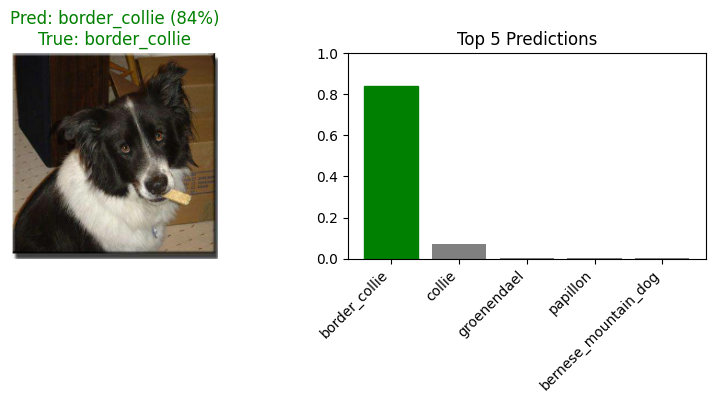

In [96]:
i = 79 # Index of the sample you want to visualize
pred_probs = predictions[i]
image = val_images[i]
true_label = val_labels[i]

# Convert true label from one-hot to label string
true_index = np.argmax(true_label)
true_label = unique_breeds[true_index]

# Get predicted label and confidence
pred_label = get_label_from_probs(pred_probs)
confidence = np.max(pred_probs) * 100

# Plot the image and prediction
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image / 255.0)  # normalize image for display
plt.axis('off')
color = 'green' if pred_label == true_label else 'red'
plt.title(f"Pred: {pred_label} ({confidence:.0f}%)\nTrue: {true_label}", color=color)

# Top 5 predictions
top_n = 5
top_indices = np.argsort(pred_probs)[-top_n:][::-1]
top_probs = pred_probs[top_indices]
top_labels = [unique_breeds[i] for i in top_indices]

# Bar chart
plt.subplot(1, 2, 2)
bars = plt.bar(range(top_n), top_probs, color='gray')
plt.xticks(range(top_n), top_labels, rotation=45, ha='right')
plt.ylim([0, 1])
plt.title(f"Top {top_n} Predictions")

# Highlight correct predictions green and false predictions red
if top_labels[0] == true_label:
  bars[0].set_color('green')
else:
  bars[0].set_color('red')

plt.tight_layout()
plt.show()